###**CASE STUDY - USING ABC CLASSIFICATION IN ANALYSIS**


>**1. BUSINESS PROBLEM**

**Domain**: A client has given us data from January 2017 to February 2017 in two files: sales and cancellations

-> Explore this data to get some first understanding of our client’s supply chain

* \* Trend of daily volume over the period
* \* Perform ABC analysis on SKUs and Clients
* \* Compute service level by SKU and by Client

>**2. EXPLORATORY DATA ANALYSIS**

>>*2.1  Overview Data* 

In [9]:
# Import pandas library and upload files
import pandas as pd
from google.colab import files
uploaded=files.upload()

Saving canceled_test.csv to canceled_test.csv
Saving sales_test.csv to sales_test.csv


In [10]:
# Read the dataset into notebook
## Sales_test
sales_test=pd.read_csv('sales_test.csv')
## Canceled_test
canceled_test=pd.read_csv('canceled_test.csv')

In [11]:
# View 5 top rows of Sales_test
sales_test.head()

,Order No,Order Date,Line No,Ship To Address No,Item Code,Order Qty,Quantity Shipped
0,528758,2017-01-03,1,1358538.0,111931,70.0,70.0
1,528791,2017-01-03,1,1254798.0,1029071,10.0,10.0
2,528791,2017-01-03,2,1254798.0,1033341,10.0,10.0
3,528791,2017-01-03,3,1254798.0,1040827,5.0,5.0
4,528791,2017-01-03,4,1254798.0,10106111,10.0,10.0


In [12]:
# View 5 top rows of Canceled_test
canceled_test.head()

,Order Number,Line Number,Order Date,Ship To Address No,Item Code,Quantity Ordered,Quantity Canceled
0,528703,1,2017-01-03,1857566.0,10135139,1,1
1,528705,1,2017-01-03,1857566.0,10135140,1,1
2,528706,2,2017-01-03,1857566.0,10135138,1,1
3,528707,1,2017-01-03,1857566.0,10135132,1,1
4,528708,1,2017-01-03,1857566.0,10135359,1,1


In [13]:
# Information about DataFrame
sales_test.info()
canceled_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28315 entries, 0 to 28314
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Order No            28315 non-null  int64  
 1   Order Date          28315 non-null  object 
 2   Line No             28315 non-null  int64  
 3   Ship To Address No  28315 non-null  float64
 4   Item Code           28315 non-null  int64  
 5   Order Qty           28315 non-null  float64
 6   Quantity Shipped    28315 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 1.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Order Number        3662 non-null   int64  
 1   Line Number         3662 non-null   int64  
 2   Order Date          3662 non-null   object 
 3   Ship To Address No  3662 non-null

In [14]:
# Change data type of "Ship to Adress No" from float to int
sales_test=sales_test.astype({'Ship To Address No':int})
canceled_test=canceled_test.astype({'Ship To Address No':int})

>>*2.2  Cleaning Data* 

>>>*2.2.1 Handling the missing or null values* 

In [15]:
# Count NA for Sales_test table
pd.isnull(sales_test).sum(axis=0)

Order No              0
Order Date            0
Line No               0
Ship To Address No    0
Item Code             0
Order Qty             0
Quantity Shipped      0
dtype: int64

In [16]:
# Count NA for Canceled_test table
pd.isnull(canceled_test).sum(axis=0)

Order Number          0
Line Number           0
Order Date            0
Ship To Address No    0
Item Code             0
Quantity Ordered      0
Quantity Canceled     0
dtype: int64

>>>*2.2.2 Dropping the duplicate rows*

In [17]:
# Total number of rows and columns for Sales test
sales_test.shape

(28315, 7)

In [18]:
# Rows containing duplicate data of Sales test
duplicate_row_sales_test=sales_test[sales_test.duplicated()]
print('Number of duplicate rows: ', duplicate_row_sales_test.shape)

Number of duplicate rows:  (0, 7)


In [19]:
# Using the same approach for Canceled test
## Total number of rows and columns
canceled_test.shape

(3662, 7)

In [20]:
# Rows containing duplicate data of Canceled test
duplicate_row_canceled_test=canceled_test[canceled_test.duplicated()]
print('Number of duplicate rows: ', duplicate_row_canceled_test.shape)

Number of duplicate rows:  (0, 7)


=> This dataset has no missing value and duplication

>>*2.3  Processing Data* 

In [21]:
# Rename some of columns for Sales_test table to match with Canceled_test one
sales_test.rename(columns={'Order No':'Order Number','Line No':'Line Number','Order Qty':'Quantity Ordered'},inplace=True)
sales_test.head()

,Order Number,Order Date,Line Number,Ship To Address No,Item Code,Quantity Ordered,Quantity Shipped
0,528758,2017-01-03,1,1358538,111931,70.0,70.0
1,528791,2017-01-03,1,1254798,1029071,10.0,10.0
2,528791,2017-01-03,2,1254798,1033341,10.0,10.0
3,528791,2017-01-03,3,1254798,1040827,5.0,5.0
4,528791,2017-01-03,4,1254798,10106111,10.0,10.0


In [22]:
# Concatenate Canceled_test into Sales_test to get Data_test
data_test=pd.concat([sales_test,canceled_test],ignore_index=True)
data_test

,Order Number,Order Date,Line Number,Ship To Address No,Item Code,Quantity Ordered,Quantity Shipped,Quantity Canceled
0,528758,2017-01-03,1,1358538,111931,70.0,70.0,NaN
1,528791,2017-01-03,1,1254798,1029071,10.0,10.0,NaN
2,528791,2017-01-03,2,1254798,1033341,10.0,10.0,NaN
3,528791,2017-01-03,3,1254798,1040827,5.0,5.0,NaN
4,528791,2017-01-03,4,1254798,10106111,10.0,10.0,NaN
...,...,...,...,...,...,...,...,...
31972,543485,2017-02-25,8,2203715,10135140,3.0,NaN,3.0
31973,543488,2017-02-25,6,2203449,1040468,2.0,NaN,2.0
31974,543488,2017-02-25,7,2203449,1040466,1.0,NaN,1.0
31975,543491,2017-02-25,5,2203449,10135358,21.0,NaN,21.0


>>*2.4  Data Analysis*

In [23]:
# Import libraries
import numpy as np
from termcolor import colored
import matplotlib.pyplot as plt
import seaborn as sns

>>>*2.4.1  Plot the daily volume over the period* 

In [24]:
# Summary statistics for daily volume
Volume_by_day=pd.pivot_table(data_test, values=['Quantity Ordered'], index='Order Date', aggfunc='sum').reset_index()
Volume_by_day['Quantity Ordered'].describe()

count       52.000000
mean      4137.461538
std       3553.518960
min          2.000000
25%       1667.000000
50%       3608.000000
75%       5073.750000
max      17320.000000
Name: Quantity Ordered, dtype: float64

**We see**:
The mean of daily volume is 4137 while the standard deviation is 3553

=> Show that the  daily demand fluctuation is quite high compared to the average value

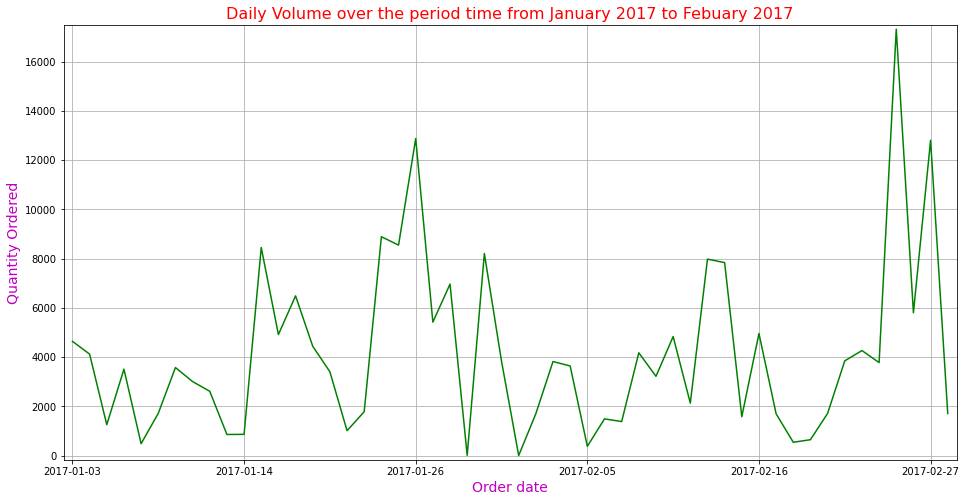

In [25]:
# Plot the daily volume over the period 
Volum_by_day=data_test.groupby('Order Date')['Quantity Ordered'].sum()
Volum_by_day.plot(color='g',figsize=(16,8),grid=True)
plt.title('Daily Volume over the period time from January 2017 to Febuary 2017', color='red',fontsize=16)
plt.xlabel('Order date',color='m',fontsize=14)
plt.ylabel('Quantity Ordered',color='m',fontsize=14)
plt.margins(0.01)
plt.show()

Based on the graph of two first months in 2017, we realize that demand fluctuation through the quantity of orders tends to increase within 1-2 weeks of the end of each month.  The weeks in early-month is significantly  lower.

In addition, the number of orders decreased sharply since mid-February then skyrocketed in the last week of the month.


>>>*2.4.2  ABC classification of SKUs and Clients*

In [26]:
# Pivot Data_test to Grou by SKU (Item Code) and Client (Address rbySKU=pd.piNo)
GrbySKU=pd.pivot_table(data_test, values=['Quantity Ordered','Quantity Shipped'], index='Item Code', aggfunc=[np.sum])
GrbyClient=pd.pivot_table(data_test,values=['Quantity Ordered','Quantity Shipped'], index='Ship To Address No', aggfunc=[np.sum])

In [27]:
# Rename columns and Sort Sum of Quantity Ordered in descending for GroupbySKU 
print(colored('Groupby SKU','blue'))
GrbySKU.columns=[''.join(col) for col in GrbySKU.columns]
GrbySKU=GrbySKU.sort_values('sumQuantity Ordered',ascending=False).reset_index()
print(GrbySKU)
print('-'*70)
print(colored('Groupby Client','blue'))
GrbyClient.columns=[''.join(col) for col in GrbyClient.columns]
GrbyClient=GrbyClient.sort_values('sumQuantity Ordered',ascending=False).reset_index()
print(GrbyClient)

Groupby SKU
    Item Code  sumQuantity Ordered  sumQuantity Shipped
0    10098739              29031.0              27173.0
1      111931              21890.0              15575.0
2     1041106              14269.0              13178.0
3     1040765              13845.0              11980.0
4      110441              10030.0               9600.0
..        ...                  ...                  ...
74    1039467                  5.0                  5.0
75   10118567                  5.0                  5.0
76   10102556                  2.0                  0.0
77    1035986                  1.0                  0.0
78   10115790                  1.0                  1.0

[79 rows x 3 columns]
----------------------------------------------------------------------
Groupby Client
     Ship To Address No  sumQuantity Ordered  sumQuantity Shipped
0               1795849              20907.0              14599.0
1               1255548              12375.0              11567.0
2        

In [28]:
# Compute Volume cumulative sum in percentage of total by SKUs and Clients
GrbySKU['%Volume in Cumsum']=round(GrbySKU['sumQuantity Ordered'].cumsum()/GrbySKU['sumQuantity Ordered'].sum()*100,1)
GrbyClient['%Volume in Cumsum']=round(GrbyClient['sumQuantity Ordered'].cumsum()/GrbyClient['sumQuantity Ordered'].sum()*100,1)

In [30]:
# Classify SKUs & Clients by ABC
## Create a function that operates on the row like so:
def f(row):
  if   row['%Volume in Cumsum'] < 80 :
        val="A"
  elif row['%Volume in Cumsum'] > 95 :
        val="C"
  else:
        val="B"
  return val
## Then apply it to GrbySKU, GrbyClient passing in the axis=1 option:
GrbySKU['Classification']=GrbySKU.apply(f, axis=1)
GrbyClient['Classification']=GrbyClient.apply(f, axis=1)

In [31]:
# Specify Number of SKUs and Clients in Cummulative sum match with %Volume in Cumsum
GrbySKU['No SKU in Cumsum']=GrbySKU.index+1
GrbyClient['No Client in Cumsum']=GrbyClient.index+1
# Perform ABC Classification on SKU and Client
ABCSKU=pd.pivot_table(GrbySKU, values=['Item Code'], index='Classification', aggfunc='count').reset_index()
ABCClient=pd.pivot_table(GrbyClient,values=['Ship To Address No'], index='Classification', aggfunc='count').reset_index()
ABCSKU['%No SKU']=round(((ABCSKU['Item Code']/ABCSKU['Item Code'].sum())*100),0)
ABCClient['%No Client']=round(((ABCClient['Ship To Address No']/ABCClient['Ship To Address No'].sum())*100),0)
ABCcategory=pd.merge(ABCSKU,ABCClient,on='Classification',how='outer')

ABC Classification of SKUs and Clients


,Classification,Item Code,%No SKU,Ship To Address No,%No Client
0,A,22,28.0,50,7.0
1,B,18,23.0,272,37.0
2,C,39,49.0,409,56.0


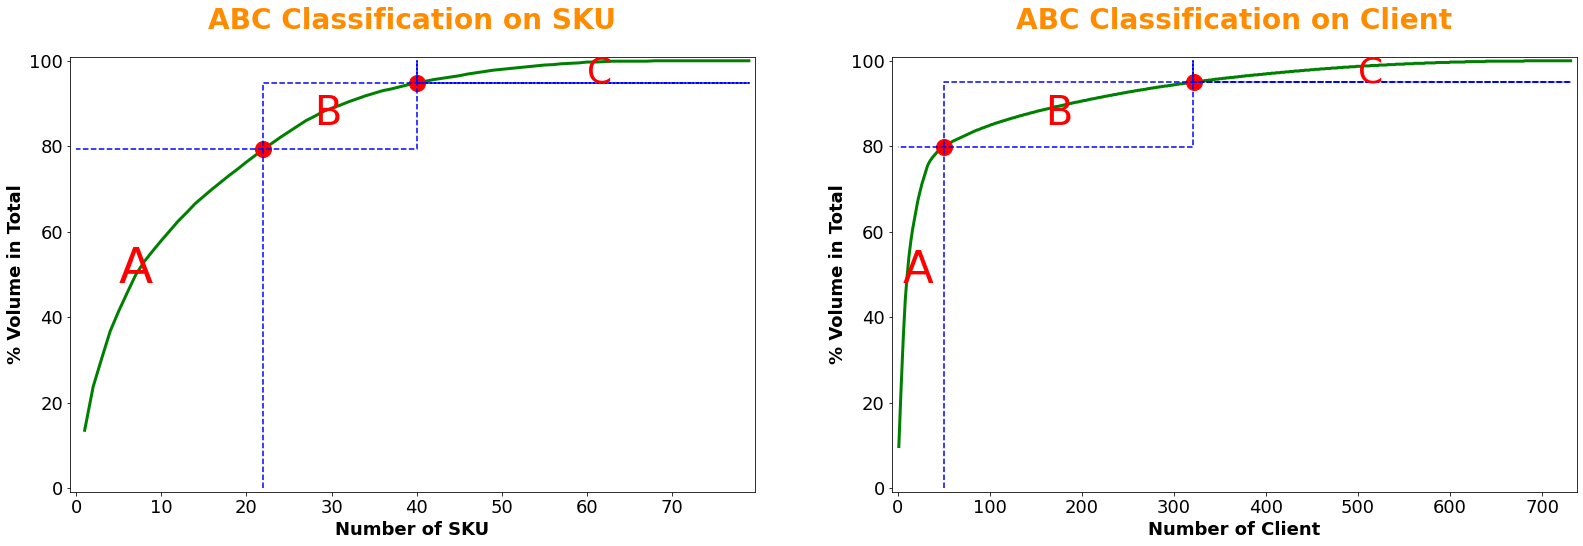

In [32]:
# Display ABC Classification of SKUs and Clients in table
print(colored('ABC Classification of SKUs and Clients','red'))
display(ABCcategory)

# Grap of ABC Classification on SKU and Client
x=GrbySKU['No SKU in Cumsum']
y=GrbySKU['%Volume in Cumsum']
z=GrbyClient['No Client in Cumsum']
t=GrbyClient['%Volume in Cumsum']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(27,8))
## Plot of SKU Classification
plt.subplot(1,2,1)
plt.plot(x,y,linestyle='-',linewidth=3, color='green')
plt.title('ABC Classification on SKU',color='darkorange',fontsize=28,fontweight='bold',y=1.05)
plt.xlabel('Number of SKU',fontsize=18, fontweight='bold')
plt.ylabel('% Volume in Total',fontsize=18,fontweight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.margins()
### Specify intersections for ABC category
x1=[22,22+18]
y1=(GrbySKU['%Volume in Cumsum'].values[[22-1,22+18-1]])
plt.plot(x1,y1, marker='o', markersize=16, color='r',
         linestyle='none')
### Plot some more auxiliary lines to help divide ABC category
x2=[22,22,22,79,40,40,40,0]
y2=[0,79.3,94.8,94.8,94.8,100,79.3,79.3]
plt.plot(x2,y2,linestyle='--',color='blue')
plt.margins(0.009)
plt.text(5,48,"A",size=50,color='red')
plt.text(28,85,"B",size=40,color='red')
plt.text(60,95,"C",size=36,color='red')

## Do the same like that to plot for Client Classification
plt.subplot(1,2,2)
plt.plot(z,t,linestyle='-',linewidth=3, color='green')
plt.title('ABC Classification on Client',color='darkorange',fontsize=28,fontweight='bold',y=1.05)
plt.xlabel('Number of Client',fontsize=18, fontweight='bold')
plt.ylabel('% Volume in Total',fontsize=18,fontweight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.margins()
### Specify intersections for ABC category
z1=[50,50+272]
t1=(GrbyClient['%Volume in Cumsum'].values[[50-1,50+272-1]])
plt.plot(z1,t1, marker='o', markersize=16, color='r',
         linestyle='none')
### Plot some more auxiliary lines to help divide ABC category
z2=[50,50,50,731,321,321,321,0]
t2=[0,79.9,95,95,95,100,79.9,79.9]
plt.plot(z2,t2,linestyle='--',color='blue')
plt.margins(0.009)
plt.text(5,48,"A",size=45,color='red')
plt.text(160,85,"B",size=40,color='red')
plt.text(500,95,"C",size=36,color='red')

plt.show()


*Assume that the profit values of all items are the same*

**Regarding ABC classification on SKU**

See data from table and graph, we find out that:
* \* 80% demand is just concentrated in 28% total quantity of SKU .This group of products is classified as A, the most important to the business
* \* Group B has nearly the same number of SKU as group A ( 18 vs 22) but contributes less to the business
* \* C is the biggest group of products, accounting for 49% ≈ 50% of the total SKU which contribute the least

**Regarding ABC classification on Client**

Using the same approach, having:
* \* 80% demand just come from 7% total quantity of client only. This group of customer is classified as A, the most important to the business
* \* Group B  is a little larger (272 vs 50) but contributes less to the business
* \* C is the biggest group of customer, accounting for 56% ( >50%)  of the total client which contribute the least

*In general, C articles (C SKU or C Client) often require a lot of attention because of their vilatility and the complexity of properly forecasting their future demand. While A articles are most important to the business, therefore they should receive proper attention and should not be neglected*.


>>>*2.4.3  Compute service level by SKU and by client* 

In [33]:
# Caculate Service level in percentage per SKUs and Clients
GrbySKU['Service level']=round(GrbySKU['sumQuantity Shipped']/GrbySKU['sumQuantity Ordered']*100,1)
GrbyClient['Service level']=round(GrbyClient['sumQuantity Shipped']/GrbyClient['sumQuantity Ordered']*100,1)
print(colored('Service level by SKU:','blue'))
display(GrbySKU[['Item Code','Service level']])
print(colored('Service level by Client:','blue'))
display(GrbyClient[['Ship To Address No','Service level']])

Service level by SKU:


,Item Code,Service level
0,10098739,93.6
1,111931,71.2
2,1041106,92.4
3,1040765,86.5
4,110441,95.7
...,...,...
74,1039467,100.0
75,10118567,100.0
76,10102556,0.0
77,1035986,0.0


Service level by Client:


,Ship To Address No,Service level
0,1795849,69.8
1,1255548,93.5
2,1255123,98.8
3,1740542,94.1
4,1255216,63.3
...,...,...
726,1255344,100.0
727,2068671,0.0
728,1255451,100.0
729,1255436,0.0


In [34]:
# Evaluate the Service level according as 3 Rank: Low (<80%), Medium(80%-95%) and High (>95%)
## Create a function that operates on the row like so:
def f1(row):
  if   row['Service level'] < 80 :
        val="Low"
  elif row['Service level'] > 95 :
        val="High"
  else:
        val="Medium"
  return val
## Then apply it to GrbySKU, GrbyClient passing in the axis=1 option:
GrbySKU['Service Ranking']=GrbySKU.apply(f1, axis=1)
GrbyClient['Service Ranking']=GrbyClient.apply(f1, axis=1)

In [35]:
# Dertermine Percentage (%) in total quantity of SKU and Client by three Serive Ranking
RankSKU=pd.pivot_table(GrbySKU, values=['Item Code'], index='Service Ranking', aggfunc='count').reset_index()
RankClient=pd.pivot_table(GrbyClient,values=['Ship To Address No'], index='Service Ranking', aggfunc='count').reset_index()
RankSKU['SKU']=round(((RankSKU['Item Code']/RankSKU['Item Code'].sum())*100),0)
RankClient['Client']=round(((RankClient['Ship To Address No']/RankClient['Ship To Address No'].sum())*100),0)
ServiceRank=pd.merge(RankSKU,RankClient,on='Service Ranking',how='outer')
ServiceRank=ServiceRank.drop(['Item Code','Ship To Address No'],axis=1)
ServiceRank=ServiceRank.transpose()
ServiceRank.columns=ServiceRank.iloc[0]
ServiceRank=ServiceRank[1:]

Service Ranking,High,Low,Medium
SKU,16,46,38
Client,34,14,52


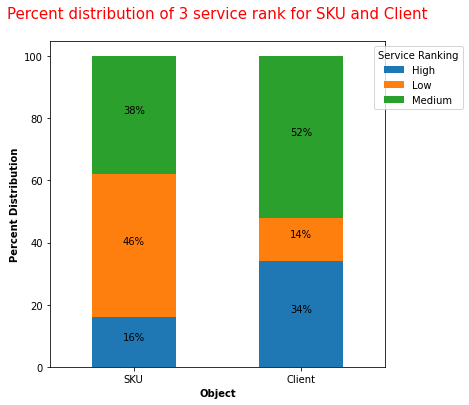

In [36]:
# Plot percent distribution of 3 service rank for each object (SKU and Client)
ServiceRank_1 = ServiceRank.plot.bar(figsize=(6,6),stacked=True, rot=0)
display(ServiceRank)

plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1.0), title="Service Ranking")

plt.title('Percent distribution of 3 service rank for SKU and Client',color='red',fontsize=15,y=1.05)
plt.xlabel('Object',fontweight='bold')
plt.ylabel('Percent Distribution',fontweight='bold')

for rec in ServiceRank_1.patches:
    height = rec.get_height()
    ServiceRank_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

* \* Most products have a low service level, accounting for 46% total number of SKU, 38% of SKUs has medium service level. Only 16% of products is evaluated as high service level.

=> Considering which features on a product or management processes can be improved to enhance service levels.

* \* Overall, the service level to clients in better condition. Over 50% (exactly is 52%) has medium service level, 14% is low and up to 34% of clients is served with high service level



In [37]:
# Dertermine service level for ABC SKU and ABC Client
a=pd.pivot_table(GrbySKU, values=['Service level'], index='Classification', aggfunc='mean')
b=pd.pivot_table(GrbyClient, values=['Service level'], index='Classification', aggfunc='mean')
a.columns=[''.join(col) for col in a.columns]
b.columns=[''.join(col) for col in b.columns]
a['Service level']=round(a['Service level'],0)
b['Service level']=round(b['Service level'],0)
a=a.sort_values('Classification',ascending=False).reset_index()
b=b.sort_values('Classification',ascending=False).reset_index()

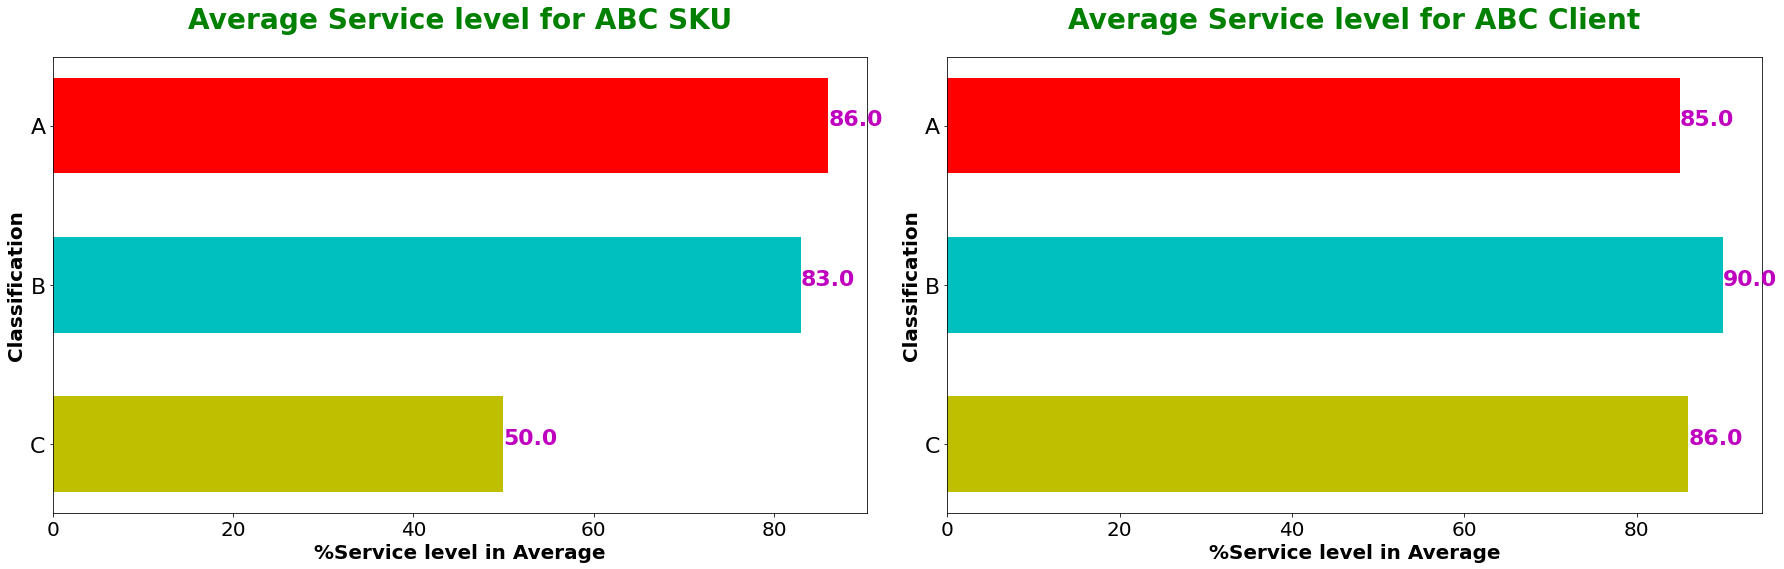

In [38]:
# Plot Average of Service level by ABC Classification for SKU and Client
x=a['Classification']
y=a['Service level']
x1=b['Classification']
y1=b['Service level']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,8))

plt.subplot(1,2,1)
plt.barh(x,y,color=['y','c','r'],height=0.6)
plt.title('Average Service level for ABC SKU',color='g',fontsize=28,fontweight='bold',y=1.05)
plt.xlabel('%Service level in Average',fontsize=20, fontweight='bold')
plt.ylabel('Classification',fontsize=20,fontweight='bold')
plt.xticks(fontsize=20)
plt.yticks(fontsize=22)
for index, value in enumerate(y):
    plt.text(value, index, str(value),fontsize = 22, fontweight ='bold', 
             color ='m')

plt.subplot(1,2,2)
plt.barh(x1,y1,color=['y','c','r'],height=0.6)
plt.title('Average Service level for ABC Client',color='g',fontsize=28,fontweight='bold',y=1.05)
plt.xlabel('%Service level in Average',fontsize=20, fontweight='bold')
plt.ylabel('Classification',fontsize=20,fontweight='bold')
plt.xticks(fontsize=20)
plt.yticks(fontsize=22)
for index, value in enumerate(y1):
    plt.text(value, index, str(value),fontsize = 22, fontweight ='bold', 
             color ='m')  
plt.tight_layout()

plt.show()

*Some insights from investigation the average of service level on*

**ABC SKU**:

 A Items have the highest service level in average - 86%, B ones are less a bit - 83% and Group C has the least value - 50%. Obviously, the higher ordered quantity of SKUs, the higher service level in average.

**ABC Client**:

There is not much difference between 3 categories(ABC Client) in average of service level, even group A has the lowest one - 85%, B has the highest - 90%  and average value of C is 86%. This means that the business is trying to please for all customers

>**3. CONCLUSION**

*From ABC concept analysis, getting some insights and  recommendations in below*

**1. For SKU**: should focus on 28% products of A group corresponding to 22 items and excute some specific strategis to maximum profit from them:

* \* Forecast the demand for products beforehand and manage the stock levels accordingly to minimize the carrying costs on the items and avoid obsolete stock

* \* Negotiate with suppliers of A category like providing post purchase services, reducing the down payment, free shipping etc.

* \* Prioritize items aligning to customer requirement to optimize inventory

* \* Increase the price of these items by a few extra dollars which will make a huge impact on the profit or consider to consolidate suppliers or transfer business to a single supplier. Purchasing more goods from a single supplier will reduce carrying costs and complexity costs associated with them

* \* Even though service level of this group is highest compared to others but it can be considered to find ways to improve further

**2. For Client**: 

* \* Start with category C, need to review the resource allocation chart  and look at where you are sending your teams and your money. From the result of computing the average of service for client above, seem your company over-emphasize the importance of these customers and spend too much time or money servicing their needs. You should look at how their sales teams are divided to see who spends time with these C customers.

* \* With this in mind, move into the B category. Look at who is servicing these customers and how often they are being serviced. Could this be improved? Could these customers benefit from an upgraded version of the current product? 

* \*Finally, check out category A. Obviously, it is the top heavy in terms of service as 80% demand come from 7% clients only ( based on above analysis) . Certainly, these are the customers that demand most of time and resources. However, if they’re spending that much money with you, there is a good chance that they are not going to leave you just because you aren’t smothering them with attention.

Take a hard look at the resources you allocate to category A customers. Determine whether there’s opportunity to share those resources with category B customers and transform them into A-level customers.

*However, based on historical dataset just include only 2 months to bring out the conclusion whether this data is reliable? In addition,  based on the above daily volume analysis, we realize that demand fluctuation is quite high so what if we have seasonal items?
For example, A items are classified as very important, however these items will not be sold in these high quanities during the rest of the year. So how many months' worth of data and when to perform the analysis exactly is of high importance*.
